# Stage 5 (2.3 catboost_2_stage_model)

# Импортируем библиотеки

In [1]:
from typing import Dict, Any
import warnings


# ----------------
# Data processing
# ----------------
import dill

import numpy as np
import pandas as pd

from tqdm.auto import tqdm


# ---------------------
# RecSys models imports
# ---------------------

from catboost import CatBoostRanker, Pool


# --------------
# Plotting libs
# --------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import shap


# -------------------
# Metrics Evaluation
# -------------------
from metrics import RecommenderMetrics


# -------------------
# Utils
# -------------------
from utils import get_catboost_group_id, add_score_and_rank


warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

RANDOM_STATE = 42

# Импортируем пути

In [2]:
data_path = "../data_closed/"

In [3]:
models_path = "../models/"

In [4]:
candidates_data_path = models_path + "candidates_data/"

# Модель второго уровня (ранкер)

## Ranker Data

In [36]:
# Загрузим таблицу ranker_train
with open(data_path + "ranker_train_final.dill", "rb") as f:
    ranker_train = dill.load(f)
    
# Загрузим таблицу ranker_val
with open(data_path + "ranker_val_final.dill", "rb") as f:
    ranker_val = dill.load(f)

### Выбираем колонки на которых будет обучаться ранкер

In [6]:
ranker_train.columns

Index(['user_id', 'item_id', 'ui_inter', 'cos_score', 'cos_rank', 'bm25_score',
       'bm25_rank', 'tfidf_score', 'tfidf_rank', 'lfm_score', 'lfm_rank',
       'user_hist', 'user_avg_pop', 'user_last_pop', 'title_len', 'descr_len',
       'title_word_len', 'descr_word_len', 'txt_emb_pca_0', 'txt_emb_pca_1',
       'txt_emb_pca_2', 'txt_emb_pca_3', 'txt_emb_pca_4', 'txt_emb_pca_5',
       'txt_emb_pca_6', 'txt_emb_pca_7', 'txt_emb_pca_8', 'txt_emb_pca_9',
       'brand', 'color', 'closure', 'country', 'cut', 'height', 'length',
       'material', 'model', 'neckline', 'pattern', 'pocket', 'purpose',
       'sleeve', 'img_pca_0', 'img_pca_1', 'img_pca_2', 'img_pca_3',
       'img_pca_4', 'img_pca_5', 'img_pca_6', 'img_pca_7', 'img_pca_8',
       'img_pca_9', 'item_pop', 'item_avg_hist', 'target'],
      dtype='object')

In [5]:
# Убираем таргет, айдишники
# и данные, на которых обучались модели первого уровня
FEATURES = [
    "cos_score",
    "cos_rank",
    "bm25_score",
    "bm25_rank",
    "tfidf_score",
    "tfidf_rank",
    "lfm_score",
    "lfm_rank",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "title_len",
    "descr_len",
    "title_word_len",
    "descr_word_len",
    "txt_emb_pca_0",
    "txt_emb_pca_1",
    "txt_emb_pca_2",
    "txt_emb_pca_3",
    "txt_emb_pca_4",
    "txt_emb_pca_5",
    "txt_emb_pca_6",
    "txt_emb_pca_7",
    "txt_emb_pca_8",
    "txt_emb_pca_9",
    "brand",
    "color",
    "closure",
    "country",
    "cut",
    "height",
    "length",
    "material",
    "model",
    "neckline",
    "pattern",
    "pocket",
    "purpose",
    "sleeve",
    "img_pca_0",
    "img_pca_1",
    "img_pca_2",
    "img_pca_3",
    "img_pca_4",
    "img_pca_5",
    "img_pca_6",
    "img_pca_7",
    "img_pca_8",
    "img_pca_9",
    "item_pop",
    "item_avg_hist",
]
# Из cols следующие фитчи категориальные
CATEGORIAL_FEATURES = [
    "brand",
    "color",
    "closure",
    "country",
    "cut",
    "height",
    "length",
    "material",
    "model",
    "neckline",
    "pattern",
    "pocket",
    "purpose",
    "sleeve",
]

## CatBoost Data Aggregation


In [39]:
ranker_train = ranker_train.sort_values(by="user_id")
ranker_val = ranker_val.sort_values(by="user_id")

In [41]:
train_pool = Pool(
    data=ranker_train[FEATURES],
    label=ranker_train["target"],
    group_id=get_catboost_group_id(ranker_train),
    cat_features=CATEGORIAL_FEATURES,
)

val_pool = Pool(
    data=ranker_val[FEATURES],
    label=ranker_val["target"],
    group_id=get_catboost_group_id(ranker_val),
    cat_features=CATEGORIAL_FEATURES,
)

## CatBoost Ranker


In [14]:
early_stopping_rounds = 32  # число итераций, в течение которых нет улучшения метрик

params = {
    "objective": "YetiRank", # catboost аналог lambdarank, оптимизирующий ndcg и map
    "custom_metric": [
        "NDCG:top=10",
        "NDCG:top=15",
        "NDCG:top=5",
        "NDCG:top=3",
    ],
    "iterations": 3500,
    "learning_rate": 0.07,
    "max_depth": 6,
    "num_leaves": 24,
    "min_child_samples": 100,
    "reg_lambda": 0.9,
    "early_stopping_rounds": early_stopping_rounds,
    "verbose": early_stopping_rounds // 2,  # период вывода метрик
    "random_state": RANDOM_STATE,
    "grow_policy": "Lossguide",
    "task_type": "GPU",
}

listwise_model = CatBoostRanker(**params)

listwise_model.fit(train_pool, eval_set=val_pool)


Groupwise loss function. OneHotMaxSize set to 10


Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=15;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=3;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9177988	best: 0.9177988 (0)	total: 368ms	remaining: 21m 29s
16:	total: 4.88s	remaining: 16m 38s
32:	total: 9.41s	remaining: 16m 28s
48:	total: 13.9s	remaining: 16m 21s
64:	total: 18.5s	remaining: 16m 15s
80:	test: 0.9206505	best: 0.9206505 (80)	total: 23s	remaining: 16m 11s
96:	total: 27.5s	remaining: 16m 6s
112:	total: 32.1s	remaining: 16m 2s
128:	total: 36.6s	remaining: 15m 57s
144:	total: 41.2s	remaining: 15m 52s
160:	test: 0.9214348	best: 0.9214348 (160)	total: 45.7s	remaining: 15m 47s
176:	total: 50.2s	remaining: 15m 42s
192:	total: 54.7s	remaining: 15m 37s
208:	total: 59.2s	remaining: 15m 32s
224:	total: 1m 3s	remaining: 15m 27s
240:	test: 0.9222049	best: 0.9222049 (240)	total: 1m 8s	remaining: 15m 23s
256:	total: 1m 12s	remaining: 15m 18s
272:	total: 1m 17s	remaining: 15m 14s
288:	total: 1m 21s	remaining: 15m 9s
304:	total: 1m 26s	remaining: 15m 4s
320:	test: 0.9227653	best: 0.9227653 (320)	total: 1m 30s	remaining: 15m
336:	total: 1m 35s	remaining: 14m 55s
352:	total:

In [15]:
# Dump listwise_model
with open(models_path + "CB_ranker_model.dill", "wb") as f:
    dill.dump(listwise_model, f)

## TEST RANKER

In [7]:
# Загрузим listwise_model
with open(models_path + "CB_ranker_model.dill", "rb") as f:
    listwise_model = dill.load(f)

In [8]:
# Загрузим таблицу ranker_test
with open(data_path + "ranker_test_final.dill", "rb") as f:
    ranker_test = dill.load(f)

In [9]:
ids = np.unique(get_catboost_group_id(ranker_test))[:100]

In [10]:
test_shap_pool = Pool(
    data=ranker_test[ranker_test["user_id"].isin(ids)][FEATURES],
    group_id=get_catboost_group_id(ranker_test[ranker_test["user_id"].isin(ids)]),
    cat_features=CATEGORIAL_FEATURES,
)

### SHAP plots

In [11]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(test_shap_pool)

In [25]:
# Some magic for proper catboost.Pool interpretation inside shap
shap_values.data =  ranker_test[ranker_test["user_id"].isin(ids)][FEATURES]
shap_values.feature_names = FEATURES

#### WaterFall plot

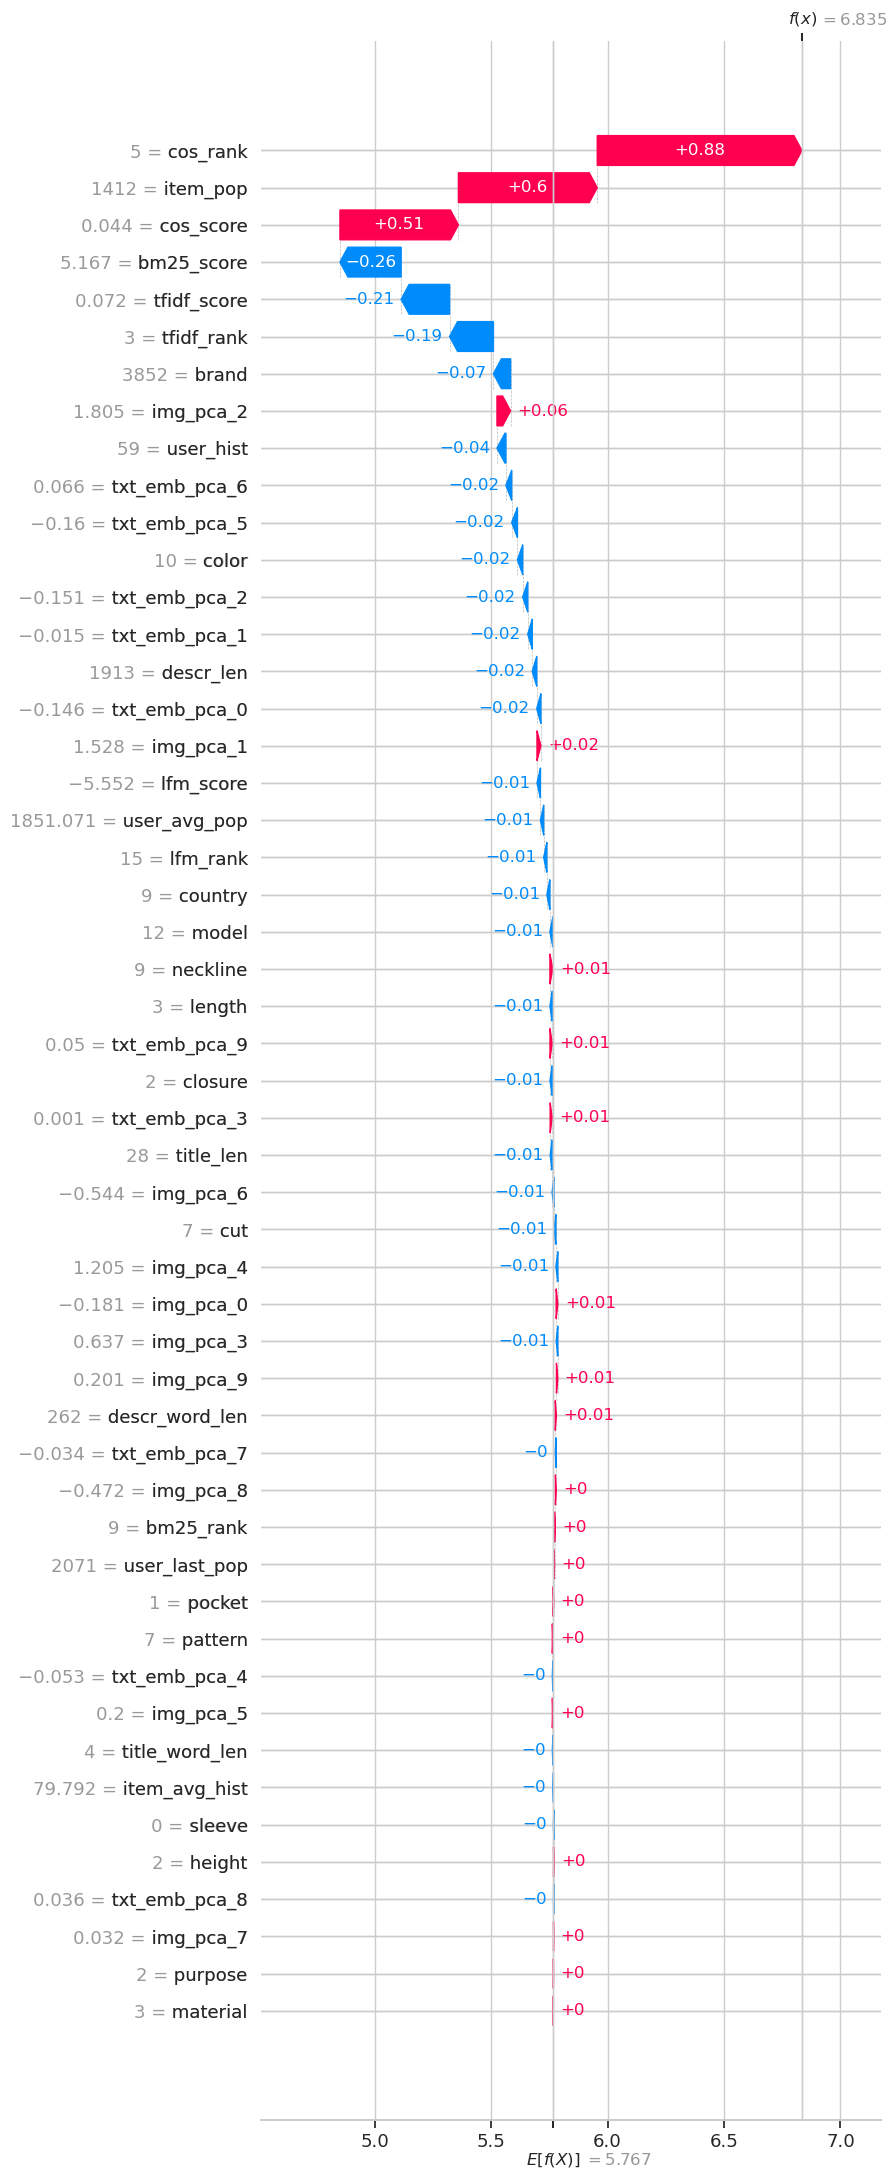

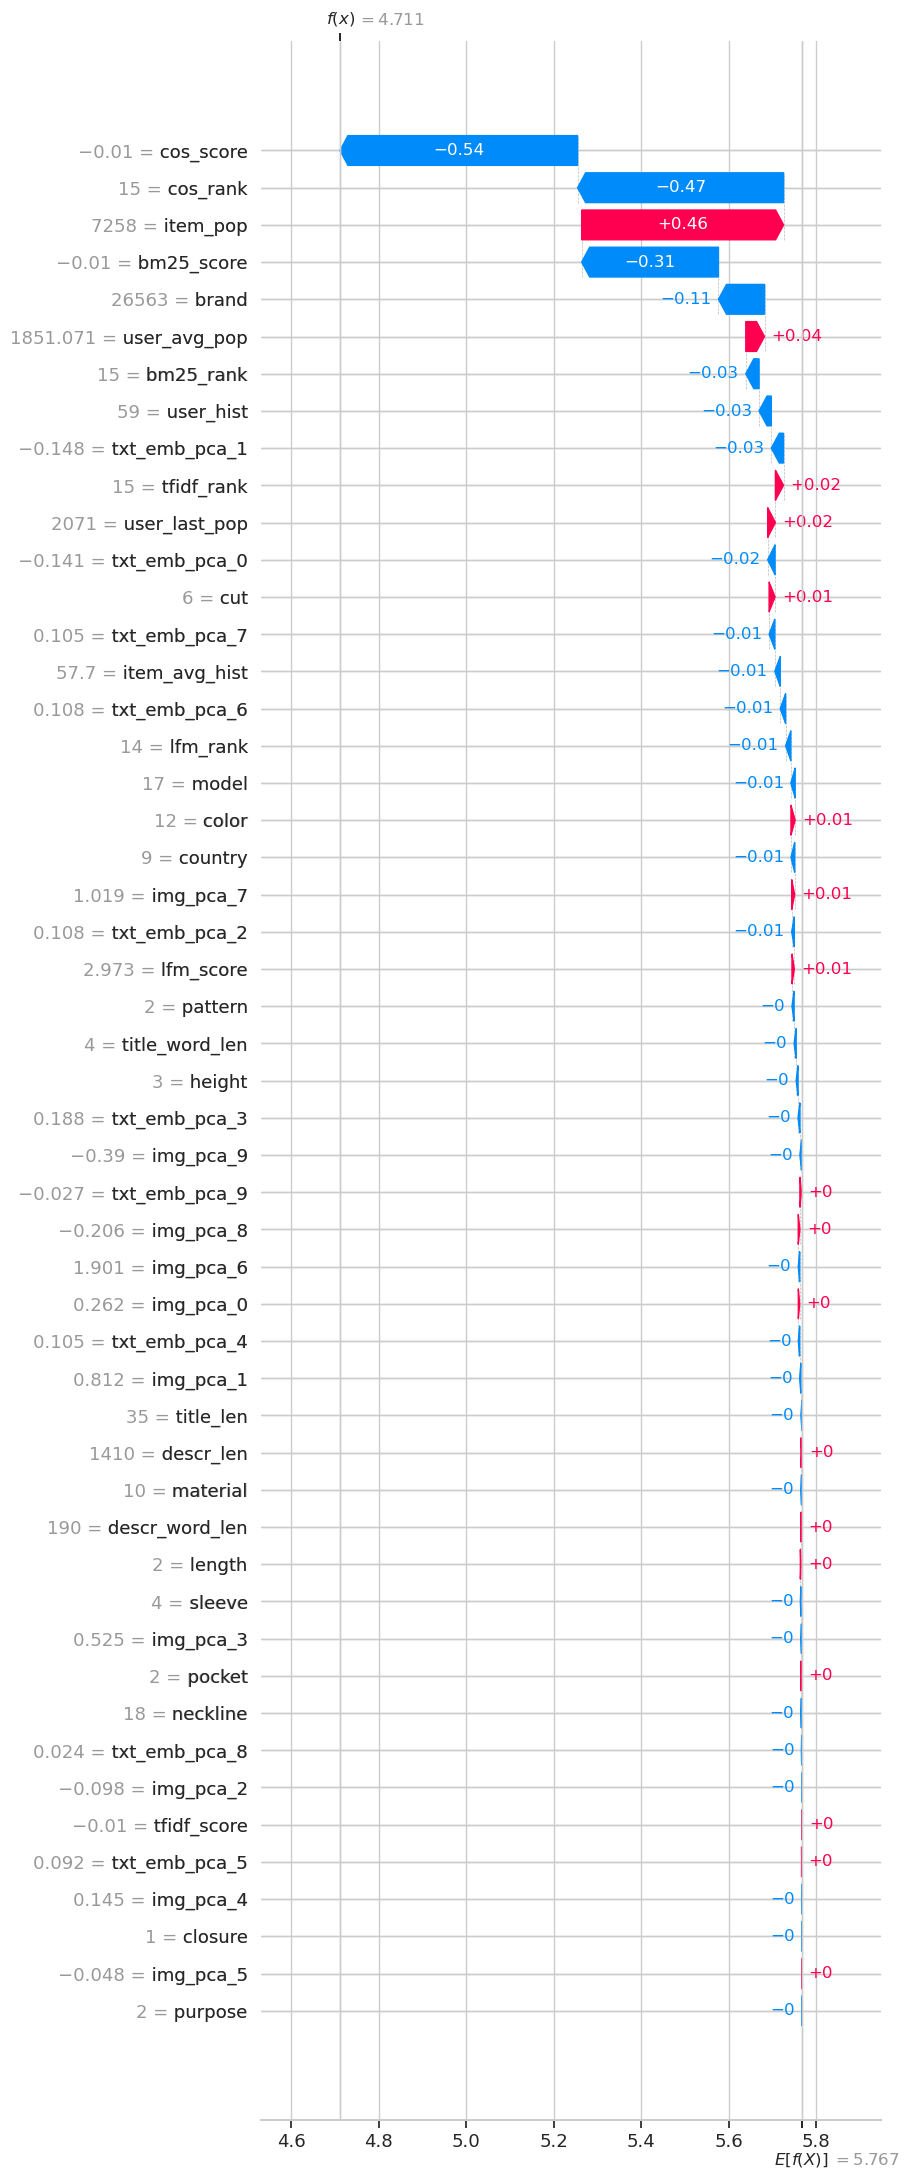

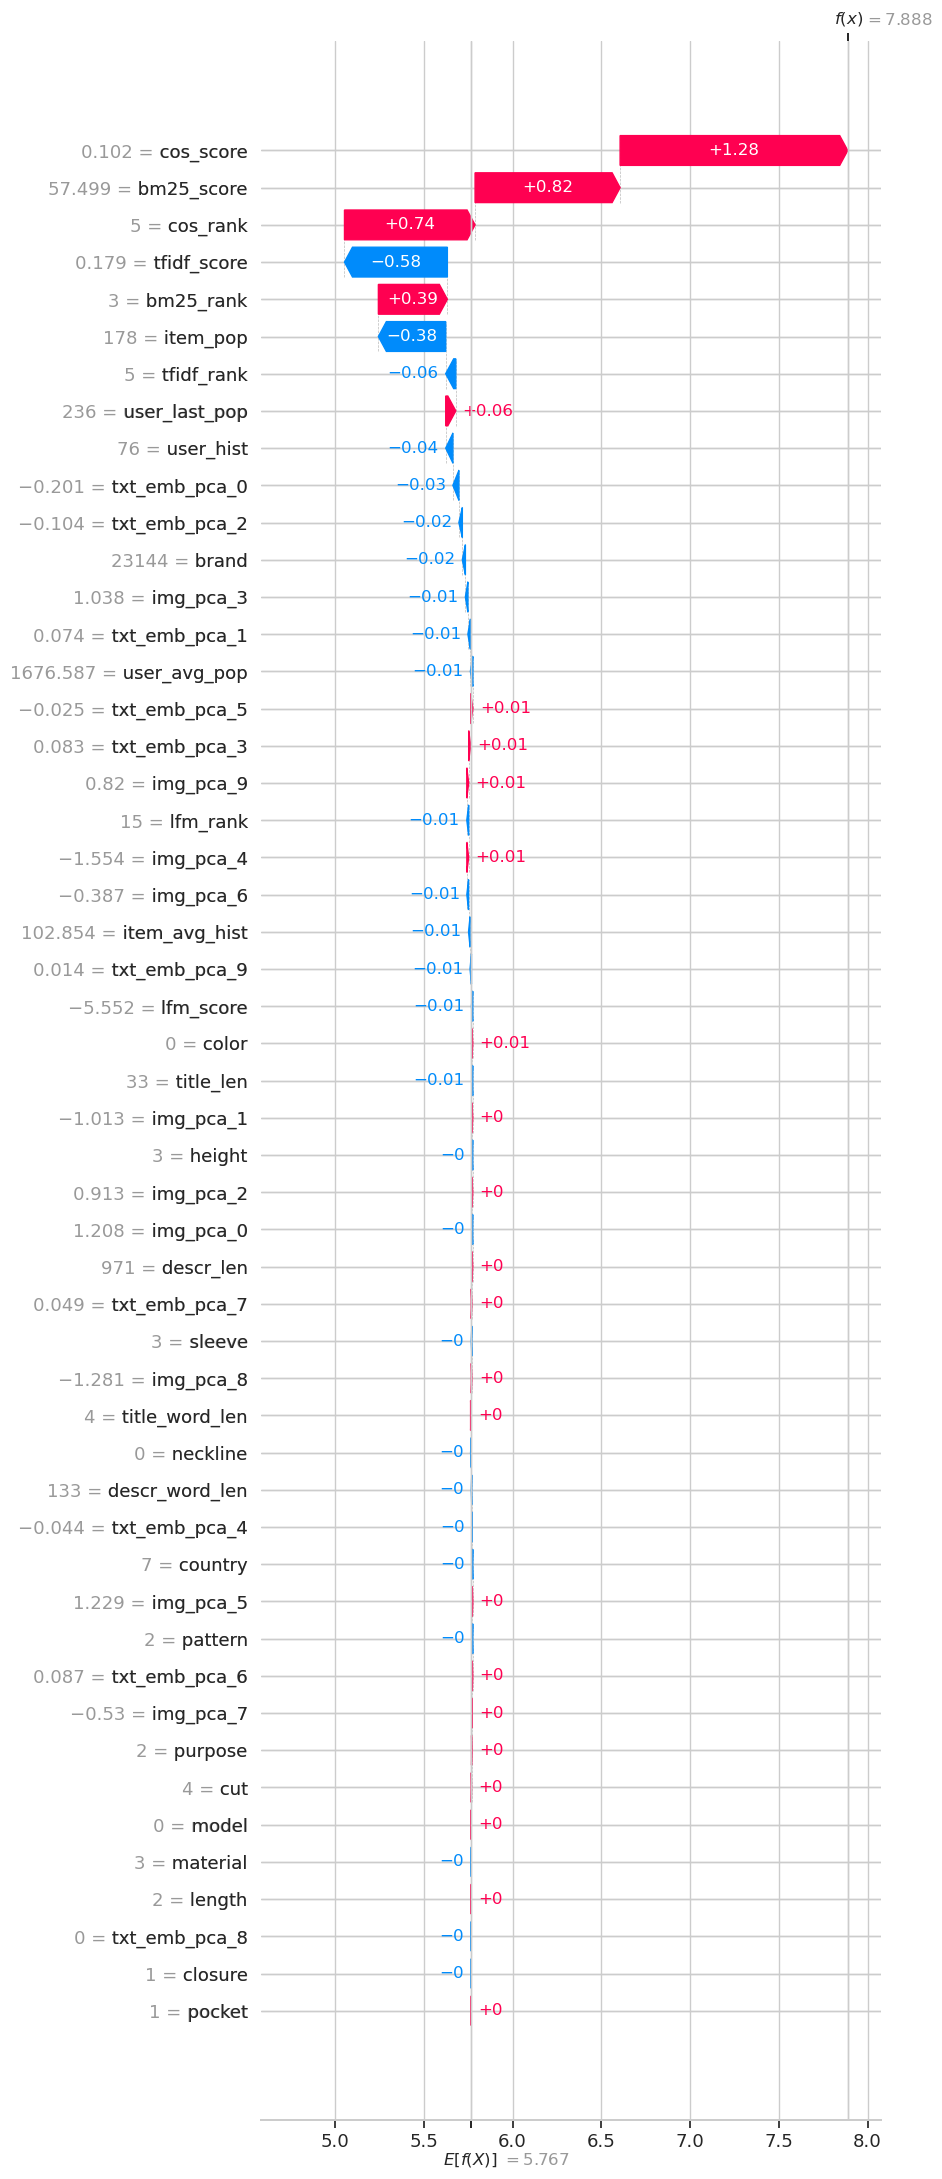

In [26]:
shap.plots.waterfall(shap_values[0], max_display=len(FEATURES))
shap.plots.waterfall(shap_values[1], max_display=len(FEATURES))
shap.plots.waterfall(shap_values[200], max_display=len(FEATURES))

#### beeswarm plot

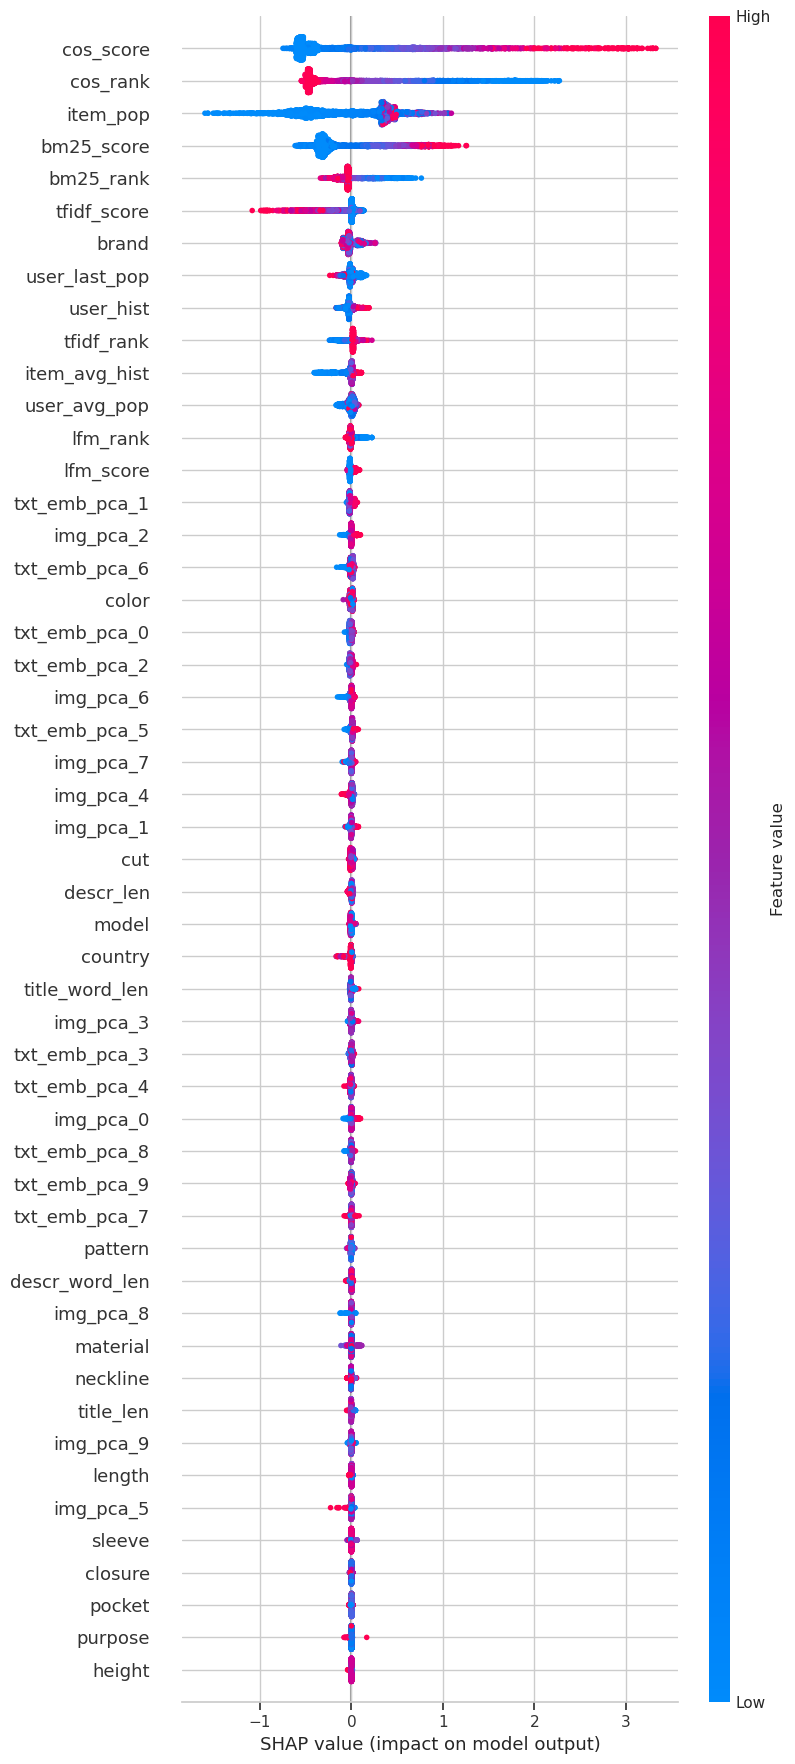

In [27]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(FEATURES))

### bar plot

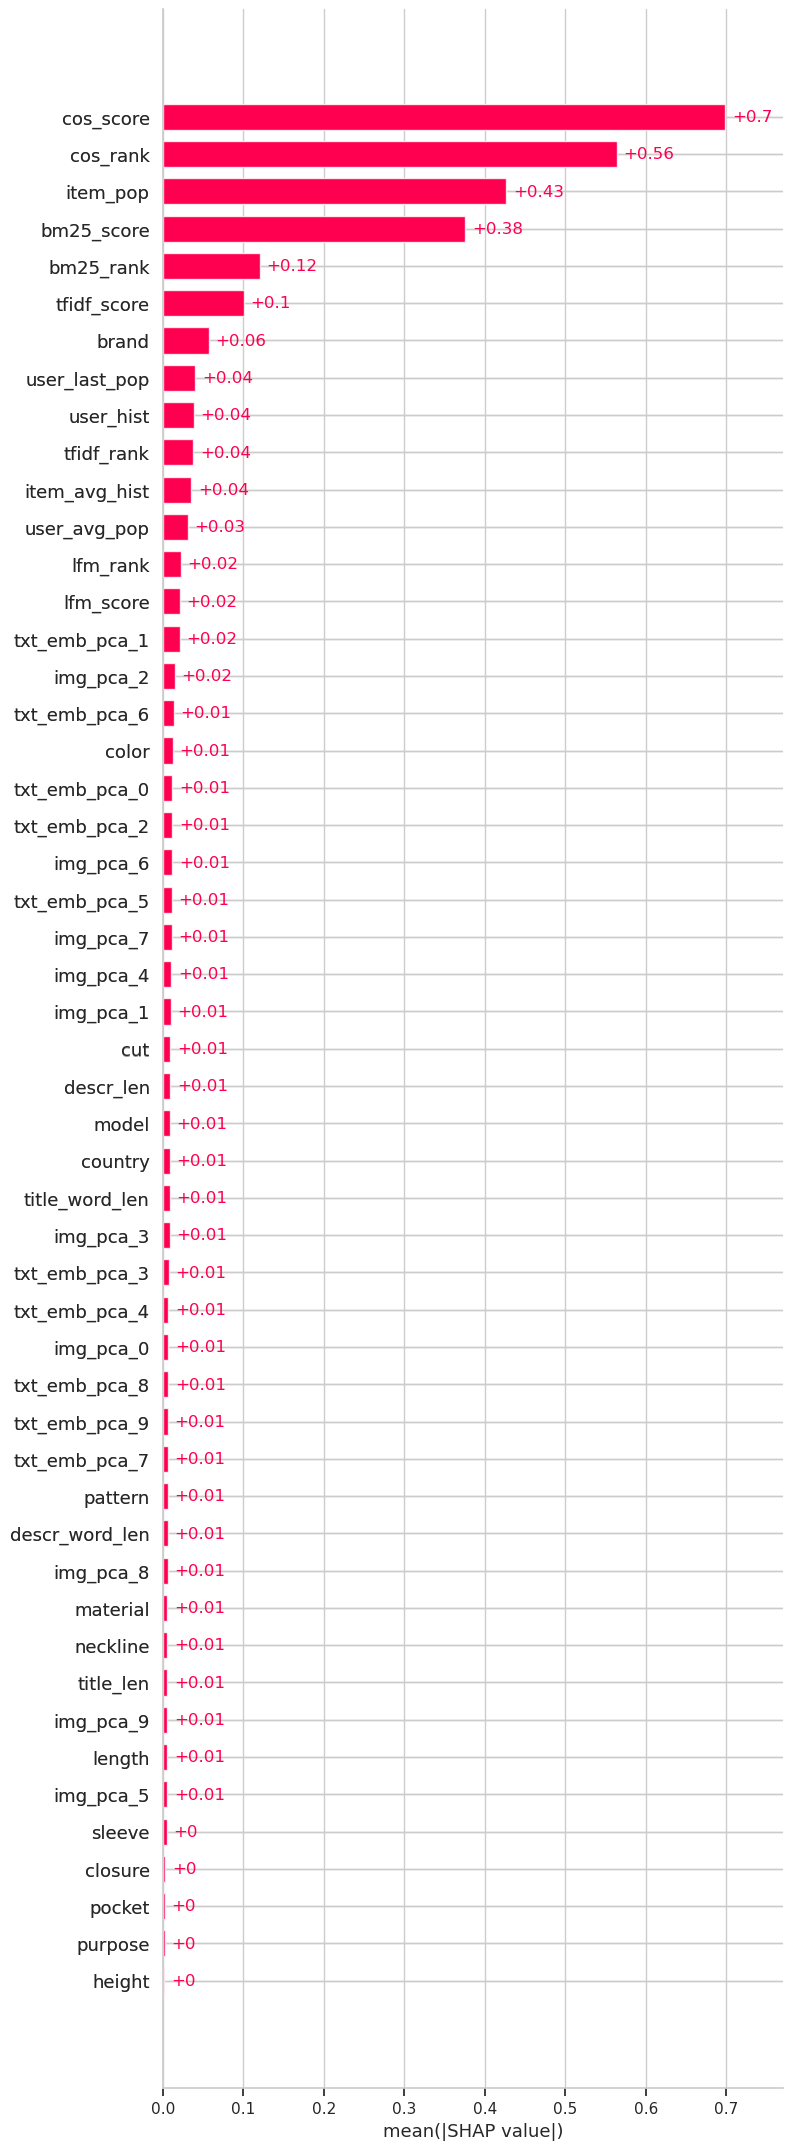

In [35]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(FEATURES))

# Выдаем рекомендации


In [6]:
# Загрузим listwise_model
with open(models_path + "CB_ranker_model.dill", "rb") as f:
    listwise_model = dill.load(f)

In [7]:
# Загрузим таблицу ranker_test
with open(data_path + "ranker_test_final.dill", "rb") as f:
    ranker_test = dill.load(f)

In [10]:
test_pool = Pool(
    data=ranker_test[FEATURES],
    group_id=get_catboost_group_id(ranker_test),
    cat_features=CATEGORIAL_FEATURES,
)

In [11]:
y_pred: np.ndarray = listwise_model.predict(test_pool)

In [ ]:
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

In [22]:
# Dump listwise_model predictions for users
with open(candidates_data_path + "CB_ranker_predictions.dill", "wb") as f:
    dill.dump(ranker_test, f)

## Считаем метрики

In [ ]:
predictions = (
    ranker_test[ranker_test["listwise_hybrid_rank"] <= 15][["user_id", "item_id"]]
    .groupby(by="user_id")["item_id"]
    .apply(list)
    .reset_index()
    .rename(columns={"item_id": "listwise_hybrid_rank_recs"})
)
predictions

In [ ]:
# Загружаем таблицу test_df
with open(data_path + "test_df.dill", "rb") as f:
    test_df = dill.load(f)
    
test_df

In [ ]:
test_df = pd.merge(
    test_df[test_df["user_id"].isin(predictions["user_id"].unique())],
    predictions,
    how="left",
    on="user_id",
)
test_df

In [21]:
for k in [3, 5, 10, 15]:
    print(
        f"""k = {k}: {RecommenderMetrics.evaluate_recommender(
            test_df, model_preds_col="listwise_hybrid_rank_recs", k=k
        )}\n"""
    )

k = 3: {'ndcg@k': 0.24283156314906526, 'recall@k': 0.14343511602251083, 'map@k': 0.17044908071629733}

k = 5: {'ndcg@k': 0.2744973783603114, 'recall@k': 0.16797300923535266, 'map@k': 0.1580102605744195}

k = 10: {'ndcg@k': 0.31324613788991085, 'recall@k': 0.19991754493295313, 'map@k': 0.14999259952494243}

k = 15: {'ndcg@k': 0.33210104763631415, 'recall@k': 0.21710946022493238, 'map@k': 0.14820307714834569}



# Выводы

Подбором параметров удалось улучшить метрики.

CatBoost показал себя хорошо на представленных данных. Относительно долгое обучение, но быстрый инференс (плюс использование gpu для вычислений)
